# Task
This assignment is about re-implementing a pipeline for binary sentiment classification (to classify film reviews as either positive or negative). A working pipeline written with sklearn is given. The task is to re-implement the feature encoding, model, a learning algorithm for the model parameters, and a prediction algorithm.

# Part 1: Parsing the dataset
I use *tarfile* to extract the data from the tar.gz file. After originally reading all the reviews and their corresponding labels (-1 or 1) into lists, I convert all the lists to np-arrays.

In [ ]:
import urllib.request
url = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz'
filename = 'data.tar.gz'
urllib.request.urlretrieve(url, filename)

('data.tar.gz', <http.client.HTTPMessage at 0x20286de4a00>)

In [ ]:
import tarfile
import os
import numpy as np

# extract tar gz 
file = tarfile.open('data.tar.gz')
file.extractall()
file.close()

# make lists of file names, one for pos and one for neg
path_neg = './txt_sentoken/neg'
dir_list_neg = os.listdir(path_neg)
path_pos = './txt_sentoken/pos'
dir_list_pos = os.listdir(path_pos)

# create empty lists X_raw_pos and X_raw_neg 
X_raw_pos = []
X_raw_neg = []

# iterate over file-name-lists, add file contents to X_raw_neg and X_raw_pos
for dir in dir_list_neg:
    new_file = open(f'./txt_sentoken/neg/{dir}', "r")
    file_content = new_file.read()
    X_raw_neg.append(file_content)

for dir in dir_list_pos:
    new_file = open(f'./txt_sentoken/pos/{dir}', "r")
    file_content = new_file.read()
    X_raw_pos.append(file_content)

#X_raw will be needed to create the vocabulary
X_raw = X_raw_neg + X_raw_pos

# X_raw_train is the first 800 negative and the first 800 positive reviews
# X_raw_test is the last 200 negative and the last 200 positive reviews
X_raw_train = X_raw_neg[:800] + X_raw_pos[:800]
X_raw_test = X_raw_neg[800:] + X_raw_pos[800:]

# prepare y, y_train and y_test
y_neg = [-1 for i in range(len(dir_list_neg))]
y_pos = [1 for i in range(len(dir_list_pos))]
y = y_neg + y_pos
y_train = [-1 for i in range(800)] + [1 for i in range(800)]
y_test = [-1 for i in range(200)] + [1 for i in range(200)]

# turn y, y_train and y_test into numpy arrays
y = np.array(y)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Part 2: Feature extraction
I tokenise the reviews by simply splitting them at white spaces. I create a dictionary that stores the vocabulary words as keys and their position in the ordered vocabulary as values. This allows for a faster lookup when creating the bag-of-words vectors.

In [ ]:
#create the vocabulary by iterating over the words in the reviews
ordered_vocabulary = []
for review in X_raw:
    ordered_vocabulary += review.split()

# turn the vocabulary list into a set to remove duplicates
ordered_vocabulary = set(ordered_vocabulary)

#create vocabulary dictionary that stores the words as keys and their position in the ordered vocabulary as values
dictionary_vocab = dict({(k,v) for v, k in enumerate(ordered_vocabulary)})

#turn vocabulary set back into a list so it is ordered
ordered_vocabulary = list(ordered_vocabulary)

In [ ]:
# create binary bag-of-words vectors from the training data
X_train = np.zeros(shape=(len(ordered_vocabulary),len(X_raw_train)),dtype=int)

for i,review in enumerate(X_raw_train):
    for word in review.split():
        X_train[dictionary_vocab[word],i] = 1

#add pseudo input
X_train = np.insert(X_train,0,1,axis=0)

# create binary bag-of-words vectors from the test data
X_test = np.zeros(shape=(len(ordered_vocabulary),len(X_raw_test)),dtype=int)

for i,review in enumerate(X_raw_test):
    for word in review.split():
        X_test[dictionary_vocab[word],i] = 1
        
#add pseudo input
X_test = np.insert(X_test,0,1,axis=0)

# Part 3: Learning framework
I decided to update the learning rate once per iteration using a time-based decay formula (source: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1). I also decided to use a fixed seed for initialising the weights, to ensure reproducibility. Since the loss decreases and the model's training set accuracy is at about 92.125% we can assume that it is learning. 

This part of the assignment definitely took the most time, but it was also the most educational part seeing as one had to go through the underlying mathematical formulas and really understand them to be able to implement them. 

In [ ]:
import random
import math
from numpy import ndarray
from numpy.linalg import norm

reguliser_dampening = 0.01   # lambda
learning_rate = 0.001        # gamma
decay = 0.01

class model:
    def __init__(self, learning_rate, reguliser_dampening, weights,decay,max_iterations=20):
        self.learning_rate = learning_rate
        self.reguliser_dampening = reguliser_dampening
        self.weights = weights
        self.max_iterations = max_iterations
        self.parameter_vector = []
        self.decay = decay

    def calculate_loss(self,y,X):
        regularization = (self.reguliser_dampening/2) * (norm(self.weights))
        sum_max = 0
        for i in range(X.shape[1]):
            sum_max += max(0,(1-y[i]*self.parameter_vector[i]))
        loss = regularization + sum_max
        return loss

    def gradient_cal(self,y,X):
        nabla = self.reguliser_dampening * self.weights
        for i in range(len(y)):
            if (y[i] * self.parameter_vector[i]) >= 1:
                gradient = 0
            else:
                gradient = np.multiply(-y[i],X[:,i])
            nabla += gradient

        self.weights = self.weights - self.learning_rate * nabla

    def fit(self, X, y):
        print("fitting...")
    
        self.parameter_vector = self.predict(X)   
  
        # calculate loss
        loss = self.calculate_loss(y,X)
        best_loss = loss

        # calculate new weights
        self.gradient_cal(y,X)
        
        num_iterations = 0
        consecutive_best_loss = 0 #counts how many times in a row the loss is higher than the best loss - 0.001
        while self.max_iterations > num_iterations:
            if consecutive_best_loss == 5:
                break
            num_iterations += 1
            
            # update learning rate with decay
            self.learning_rate = self.learning_rate * 1/(1 + self.decay * num_iterations)
            
            self.parameter_vector = self.predict(X)
                
            loss = self.calculate_loss(y,X)
            print(f"Epoch: {num_iterations}, current loss: {loss}")
            
            self.gradient_cal(y,X)
            
            # stop criterion
            if loss < best_loss:
                if loss > best_loss - 0.001:
                    consecutive_best_loss += 1
            else:
                consecutive_best_loss = 0 #reset to zero
            if loss < best_loss:
                best_loss = loss
                
        final_weights = self.weights
                
        return final_weights

    def predict(self,X):
        # sign function
        prediction_vector = [0 for i in range(len(X[1]))]
        for i in range(len(X[1])):
            temp = np.matmul(self.weights.transpose(),X[:,i])
            if temp > 0:
                prediction_vector[i] = 1
            elif temp < 0: 
                prediction_vector[i] = -1
            else:
                prediction_vector[i] = 0
        
        return prediction_vector   

    def score(self, X, y):
        prediction_vector = self.predict(X) # Put elements in X through the sign function
        equal = np.zeros((len(y),1),dtype="int") # np array that stores how many of the model's predictions for y are correct
        for i,element in enumerate(y):
            if element == prediction_vector[i]:
                equal[i] = 1
        sum_equal = np.sum(equal) #summing up the result of the comparison between model's predictions and actual labels
        sum_equal_len = sum_equal/len(y) #dividing result by length
        score = 100*sum_equal_len # multiplying by 100 to get a percentage
                
        return score
    

# initialising the weights, seed 75 has shown to be a good first guess
np.random.seed(75)
weights_array = 0.01*np.random.randn(len(ordered_vocabulary)+1)

# create an instance of the class model
first_model = model(learning_rate, reguliser_dampening, weights_array,decay,100)

# fit the model
fitted_weights = first_model.fit(X_train,y_train)

# get the training set accuracy
score = first_model.score(X_train,y_train)
print(f"accuracy: {score}")


fitting...
Epoch: 1, current loss: 1600.0128962735917
Epoch: 2, current loss: 1600.0326951584263
Epoch: 3, current loss: 1600.0150648357765
Epoch: 4, current loss: 1600.0337263073502
Epoch: 5, current loss: 1462.0186300438806
Epoch: 6, current loss: 1600.0325857488779
Epoch: 7, current loss: 1422.022415229327
Epoch: 8, current loss: 1600.0316737089618
Epoch: 9, current loss: 1468.025859331138
Epoch: 10, current loss: 1600.0320864820442
Epoch: 11, current loss: 1236.0288068972748
Epoch: 12, current loss: 1600.0314071503365
Epoch: 13, current loss: 1550.0312230307252
Epoch: 14, current loss: 1600.0330004051782
Epoch: 15, current loss: 1256.0330781424245
Epoch: 16, current loss: 1406.0336641903145
Epoch: 17, current loss: 1134.0341168683626
Epoch: 18, current loss: 618.034266845737
Epoch: 19, current loss: 334.03425549901357
Epoch: 20, current loss: 276.03422416989497
Epoch: 21, current loss: 274.03419902336293
Epoch: 22, current loss: 268.03417883888727
Epoch: 23, current loss: 266.03416

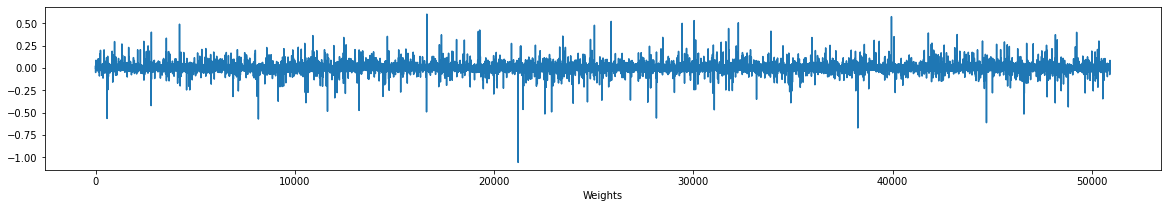

In [ ]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20, 3))
plt.plot(first_model.weights[1:])
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

In [ ]:
assert (len(first_model.weights)-1) == len(ordered_vocabulary)

# Sort by absolute value
idx = np.argsort(np.abs(first_model.weights[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:   # Pick those with highest 'voting' values
  print("%20s   %.3f\t%i " % (ordered_vocabulary[i], first_model.weights[i+1], np.sum([ordered_vocabulary[i] in d for d in X_raw])))

                Word   Weight  Occurences
            supposed   -0.475	321 
                very   0.477	1552 
                 why   -0.485	586 
                many   0.489	796 
              should   -0.492	708 
             nothing   -0.492	594 
                also   0.498	1071 
               world   0.505	643 
              stupid   -0.515	227 
                   !   -0.516	663 
                best   0.520	867 
               great   0.529	805 
                   ?   -0.561	1228 
              boring   -0.565	229 
                plot   -0.572	1002 
                both   0.574	683 
                life   0.602	895 
              script   -0.612	632 
               worst   -0.671	238 
                 bad   -1.056	825 


# Part 4: Exploring hyperparameters
The highest training set accuracy we get by exploring the hyperparameters in this way is 95.8125%. Therefore I decided to use the learning rate, reguliser dampening and decay used to get this training accuracy also to get a test set accuracy score below. The test set accuracy is 85.5% which is not as good as the original sklearn implementation but still clearly over 50%, indicating that the model was able to generalise from the training data to the test data.

In [ ]:
# create list of sample parameters where each element consists of a tuple (learning rate, reguliser dampening, decay)
parameters = []

learning_rate = np.exp(np.linspace(np.log(0.0001), np.log(3), 10))
reguliser_dampening = np.exp(np.linspace(np.log(0.0001), np.log(3), 10))
decay = np.exp(np.linspace(np.log(0.0001), np.log(3), 10))
               
for learn in learning_rate:
    for regul in reguliser_dampening:
        for dec in decay:
               parameters.append((learn,regul,dec))

# choose 10 random elements from the list
sample_parameters = random.choices(parameters, k=10)

print("learning rate:\treguliser dampening:\tdecay:\ttraining accuracy:")

#iterate through list and fit and score model once with the parameters in each tuple
for sample in sample_parameters:
    search_model = model(sample[0],sample[1],weights_array,sample[2],100)
    search_model.fit(X_train, y_train)
    score = search_model.score(X_train, y_train)
    print(f"{sample[0]}\t{sample[1]}\t{sample[2]}\t{score}")

learning rate:	reguliser dampening:	decay:	training accuracy:
fitting...
Epoch: 1, current loss: 1606.276521353997
Epoch: 2, current loss: 1628.7339383590477
Epoch: 3, current loss: 1609.6312598347245
Epoch: 4, current loss: 1629.522976287507
Epoch: 5, current loss: 1559.8830520500344
Epoch: 6, current loss: 1629.5750437544423
Epoch: 7, current loss: 1183.9415221798013
Epoch: 8, current loss: 1624.847868861924
Epoch: 9, current loss: 1621.7616608743688
Epoch: 10, current loss: 1626.6546049838157
Epoch: 11, current loss: 1588.3124728711848
Epoch: 12, current loss: 1628.03529550657
Epoch: 13, current loss: 1258.5288122834534
Epoch: 14, current loss: 1627.86581261418
Epoch: 15, current loss: 1504.2235759546293
Epoch: 16, current loss: 1554.924259640384
Epoch: 17, current loss: 1253.3224060387101
Epoch: 18, current loss: 801.470814871794
Epoch: 19, current loss: 419.4298874797524
Epoch: 20, current loss: 315.347135239857
Epoch: 21, current loss: 313.279692529539
Epoch: 22, current loss: 30

In [ ]:
# Set up the classifier
learning_rate = 0.0001

reguliser_dampening = 3

decay = 0.000988

first_model = model(learning_rate, reguliser_dampening, weights_array,decay,100)

# Train on all the non-test data
first_model.fit(X_train, y_train)

# Run prediction on the test set
test_accuracy = first_model.score(X_test,y_test)
#np.sum(model.predict(X_test)==y_test)/len(y_test)

print(f"Test set accuracy: {test_accuracy}")

fitting...
Epoch: 1, current loss: 1603.3807302225773
Epoch: 2, current loss: 1603.5017103293535
Epoch: 3, current loss: 1603.3875010423783
Epoch: 4, current loss: 1603.5160683435017
Epoch: 5, current loss: 1579.403777894947
Epoch: 6, current loss: 1603.5339396033805
Epoch: 7, current loss: 1461.4288572573375
Epoch: 8, current loss: 1603.536528988187
Epoch: 9, current loss: 1585.4616991936532
Epoch: 10, current loss: 1603.5701643450311
Epoch: 11, current loss: 1491.5012226657575
Epoch: 12, current loss: 1603.5935616438373
Epoch: 13, current loss: 1533.546664174559
Epoch: 14, current loss: 1603.6305681816875
Epoch: 15, current loss: 1513.5970873010538
Epoch: 16, current loss: 1603.6698392952403
Epoch: 17, current loss: 1513.6515669966193
Epoch: 18, current loss: 1603.7138244936568
Epoch: 19, current loss: 1511.709157751103
Epoch: 20, current loss: 1603.7612098536606
Epoch: 21, current loss: 1511.7689370756063
Epoch: 22, current loss: 1603.8119885350527
Epoch: 23, current loss: 1493.8300

# Qualitative analysis 
In the table above we can see that the words with the most negative scores tend to be negative words such as *bad* or *worst* or *boring*. Positive words such as *best* or *great* received very positive scores as expected. However, words such as *plot* and *script* which are not enherently negative also received very negative scores. This could bias the model to classify reviews as negative if they take up these words (and not a lot of other words for instance). 

My hyperparameters were learning rate, reguliser dampening, decay and the weights. I fixed the starting weights at a seed that appeared to be a good guess right from the start (as I got a fairly high accuracy even when the loss was never going down). The learning rate, reguliser dampening and decay I went with in the end are chosen based on the hyperparameter search conducted in the last section of this assignment. 

All in all, with a training set accuracy of about 96% and a test set accuracy of 85.5%, the model successfully learned to classify film reviews as positive or negative. Room for improvement exists for instance when it comes to speed; it takes a long time to run the model, potentially because I used lists quite frequently instead of faster data types. 